 Andrew J Markland, ajm259@uakron.edu\
 The University of Akron, CEPS, School of Computer Science\
 Applied Machine Learning CPSC-436-010\
 Dr. Zhong-Hui Duan\

# Project 1, kNN
 -Project Scope:\
     Apply the machine learning classification algorithm "k nearest neighbors"(kNN) to correctly classify a dataset of people based on their risk for MI, Myocardial Infarction.  

In [8]:
#imports, decided to keep that at the top to keep them global 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix


avg accuracy: 0.7577083333333333

median accuracy: 0.7598039215686274

highest accuracy: 0.8517156862745098

Lowest accuracy: 0.6813725490196079

accuracy range: 17.03431372549019%



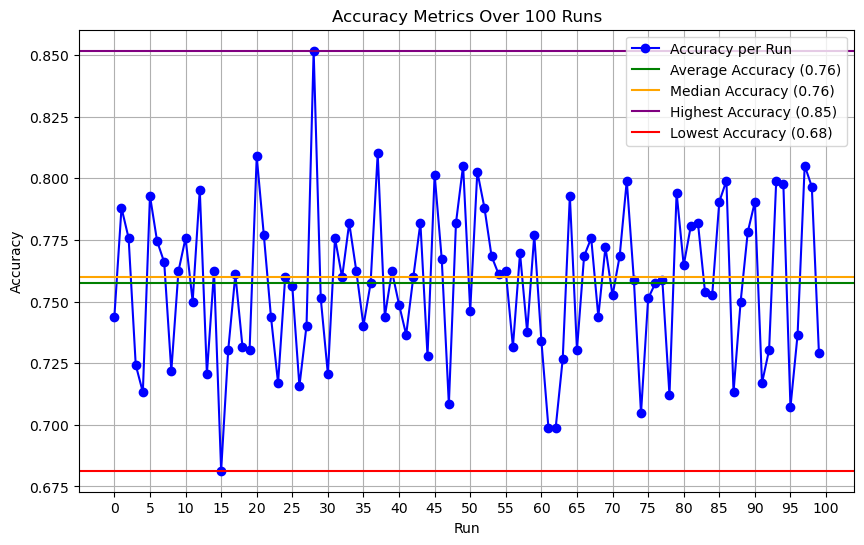

In [169]:
avgList = pd.DataFrame(columns = ['run', 'avg']).set_index('run')
for x in range(100):
    people_df = pd.read_csv("NHANES_data_train.csv")
    
#partitioning random test data and and training data
    trainDf, testDf = train_test_split(people_df, test_size = 0.2, random_state = None)
    
#Get counts of persons with MI and noMI
    MIcount = (trainDf["MI"] == 1).sum()
    noMIcount = (trainDf["MI"] == 2).sum()
    testMIcount = (testDf["MI"] == 1).sum()
    testnoMIcount = (testDf["MI"] == 2).sum()
#Isolate the same number of NoMI's as the MI subgroup
    dirtyTrainMI_sample = trainDf[trainDf["MI"] == 1]
    dirtyTrainNoMI_sample = (trainDf[trainDf["MI"] == 2]).sample(frac=(MIcount/noMIcount))
    dirtyTestMI_sample = testDf[testDf["MI"] == 1]
    dirtyTestNoMI_sample = (testDf[testDf["MI"] == 2])

#Declare imputer object and clean the data
    imputer = KNNImputer(n_neighbors = 21)
    
    crudeCleanTrainMI = imputer.fit_transform(dirtyTrainMI_sample)
    cleanTrainMI = pd.DataFrame(crudeCleanTrainMI, columns = dirtyTrainMI_sample.columns)

    crudeCleanTrainNoMI = imputer.fit_transform(dirtyTrainNoMI_sample)
    cleanTrainNoMI = pd.DataFrame(crudeCleanTrainNoMI, columns = dirtyTrainNoMI_sample.columns)

    crudeCleanTestMI = imputer.fit_transform(dirtyTestMI_sample)
    cleanTestMI = pd.DataFrame(crudeCleanTestMI, columns = dirtyTestMI_sample.columns)

    crudeCleanTestNoMI = imputer.fit_transform(dirtyTestNoMI_sample)
    cleanTestNoMI = pd.DataFrame(crudeCleanTestNoMI, columns = dirtyTestNoMI_sample.columns)
    
#fTrainSample is the final sample group to train the KNN model on, comprising the same number of
    #people with MI's and people without MI's and on a random scale
    fTrainSample = (pd.concat([cleanTrainMI, cleanTrainNoMI])).sample(frac=1)
    fTestSample = (pd.concat([cleanTestMI, cleanTestNoMI])).sample(frac=1)
    
##---------------------------------------------------------- break in data acquisition ---------------------------------------------------------------
    # metric='manhattan'
    knn = KNeighborsClassifier(n_neighbors = 21, metric='manhattan')
    scaler = StandardScaler()
    
#weights for scalaing attribute importance
    # 1:ID, 2:income, 3:sex, 4:age 5:race, 6:edu, 7:dist, 8:syst, 9:pulse, 10:BMI, 11:HDL 12:trig, 13:LDL, 14:TChol, 15:Kidney, 16:diabetes, 17:smoke, 
    # 18:active, 19:insured
    #                    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18   19
    weights = np.array([1.0, 0.5, 0.5, 1.2, 0.5, 0.4, 1.5, 1.0, 1.3, 0.4, 1.0, 1.5, 1.0, 1.5, 1.0, 1.0, 1.0, 2.0, 1.0])

    #clean wieghts
#   weights = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

#Prepping the training data to train the model
    x_train = scaler.fit_transform(fTrainSample.drop("MI", axis=1)) * weights  
    y_train = fTrainSample["MI"]
    knn.fit(x_train, y_train)

#prepping the test data to check the model
    x_test = scaler.transform(fTestSample.drop("MI", axis=1)) * weights
    y_test = fTestSample["MI"]
    
#testing the model
    predictions = knn.predict(x_test)
    
#logging accuracy to check the model
    accuracy = accuracy_score(y_test, predictions)
    #print(f"Model accuracy: {accuracy}")
    avgList.loc[x, 'avg'] = accuracy

##------------------------------------------------------------ break in data analysis -----------------------------------------------------------------

print("avg accuracy: " + str(avgList['avg'].mean()) + '\n')
print("median accuracy: " + str(avgList['avg'].median()) + '\n')
print("highest accuracy: " + str(avgList['avg'].max()) + '\n')
print("Lowest accuracy: " + str(avgList['avg'].min()) + '\n')
print("accuracy range: " + str((avgList['avg'].max() - avgList['avg'].min()) * 100) + '%\n')


# Plotting the accuracy values
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(avgList.index, avgList['avg'], label='Accuracy per Run', marker='o', linestyle='-', color='blue')

# Calculating the statistics
average_accuracy = avgList['avg'].mean()
median_accuracy = avgList['avg'].median()
highest_accuracy = avgList['avg'].max()
lowest_accuracy = avgList['avg'].min()

# Adding lines for average, median, highest, and lowest
plt.axhline(y=average_accuracy, color='green', linestyle='-', label=f'Average Accuracy ({average_accuracy:.2f})')
plt.axhline(y=median_accuracy, color='orange', linestyle='-', label=f'Median Accuracy ({median_accuracy:.2f})')
plt.axhline(y=highest_accuracy, color='purple', linestyle='-', label=f'Highest Accuracy ({highest_accuracy:.2f})')
plt.axhline(y=lowest_accuracy, color='red', linestyle='-', label=f'Lowest Accuracy ({lowest_accuracy:.2f})')

plt.legend()
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Accuracy Metrics Over 100 Runs')
plt.xticks(range(0, 101, 5))  # Adjust x-axis ticks if necessary
plt.grid(True)  # Adds a grid for better readability

plt.show()
